# Статистический анализ на данных GoFast

Работа с данными о некоторых пользователях из нескольких городов, а также об их поездках. Необходимо проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. <br>
Сервисом можно пользоваться:
- без подписки:
    - абонентская плата отсутствует;
    - стоимость одной минуты поездки — 8 рублей;
    - стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra:
    - абонентская плата — 199 рублей в месяц;
    - стоимость одной минуты поездки — 6 рублей;
    - стоимость старта — бесплатно.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

### Загрузка данных

In [3]:
users_df = pd.read_csv('/datasets/users_go.csv')
rides_df = pd.read_csv('/datasets/rides_go.csv')
subs_df = pd.read_csv('/datasets/subscriptions_go.csv')

In [4]:
users_df.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [5]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


#### Описание данных пользователей (users_df):
user_id - уникальный идентификатор пользователя (int64) <br>
name - имя пользователя (object) <br>
age - возраст (int64) <br>
city - город (object) <br>
subscription_type - тип подписки (free, ultra) (object)

In [6]:
rides_df.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [7]:
rides_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


#### Описание данных поездок (rides_df):
user_id - уникальный идентификатор пользователя (int64) <br>
distance - расстояние, которое пользователь проехал в текущей сессии (в метрах) (float64) <br>
duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку» (float64) <br>
date - дата совершения поездки (object)

In [8]:
subs_df.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [9]:
subs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


#### Описание данных подписок (subs_df):
subscription_type - тип подписки (object) <br>
minute_price - стоимость одной минуты поездки по данной подписке (int64) <br>
start_ride_price - стоимость начала поездки (int64) <br>
subscription_fee - стоимость ежемесячного платежа (int64)

### Предобработка данных

#### Приведем столбец date к типу даты pandas

In [10]:
try:
    rides_df['date'] = pd.to_datetime(rides_df['date'], format = '%Y-%m-%d')
except:
    print('Date convertion is failed.')

In [11]:
rides_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


#### Создайте новый столбец с номером месяца на основе столбца date

In [12]:
rides_df['month'] = rides_df['date'].dt.month

In [13]:
rides_df.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


#### Проверка и обработка пропущенных значений и дубликатов в датафреймах

In [14]:
users_df.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [15]:
rides_df.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [16]:
subs_df.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [17]:
users_df.duplicated().sum()

31

In [18]:
users_df.drop_duplicates(inplace=True)

In [19]:
users_df.duplicated().sum()

0

In [20]:
rides_df.duplicated().sum()

0

In [21]:
subs_df.duplicated().sum()

0

#### Выводы предобработки данных:
- Столбец date переведен к типу datetime64;
- В датафрейме rides_df создан новый столбец (Месяц совершения поездки);
- Пропущенные значения ни в одном датасете найдены не были;
- Выявлены и удалены 31 дубликат в users_df;
- В rides_df subs_df дубликаты отсутствуют.


### Исследовательский анализ данных

#### Частота встречаемости городов

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64


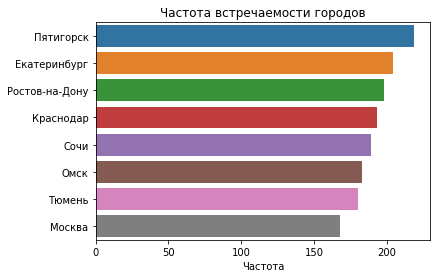

In [22]:
freq_city = users_df['city'].value_counts()
print(freq_city)
ax = sns.barplot(x=freq_city, y=freq_city.index);
ax.set_title('Частота встречаемости городов');
ax.set_xlabel('Частота');

#### Соотношение пользователей с подпиской и без подписки

free     835
ultra    699
Name: subscription_type, dtype: int64


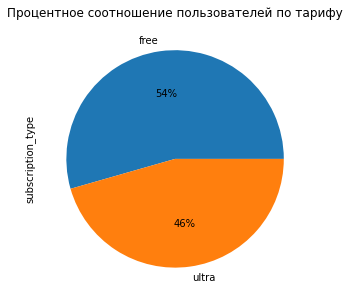

In [23]:
print(users_df['subscription_type'].value_counts())
users_df['subscription_type'].value_counts().plot(y=users_df['subscription_type'].value_counts(), kind = 'pie', 
                                                  autopct='%1.0f%%', figsize=(5,5), 
                                                  title='Процентное соотношение пользователей по тарифу');

#### Возраст пользователей

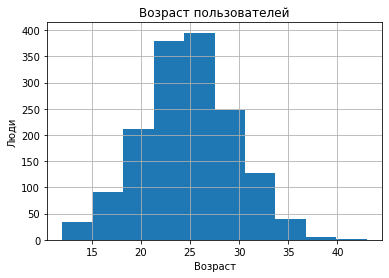

In [24]:
plt.hist(users_df['age'], bins=10)
plt.xlabel('Возраст')
plt.ylabel('Люди')
plt.title('Возраст пользователей')
plt.grid()

#### Расстояние, которое пользователь преодолел за одну поездку

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64


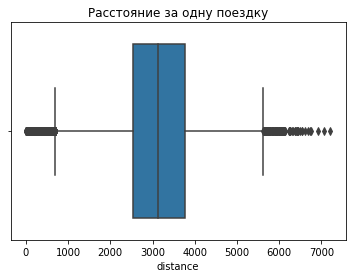

In [25]:
print(rides_df['distance'].describe())
sns.boxplot(x=rides_df['distance']).set_title('Расстояние за одну поездку');

#### Продолжительность поездок

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64


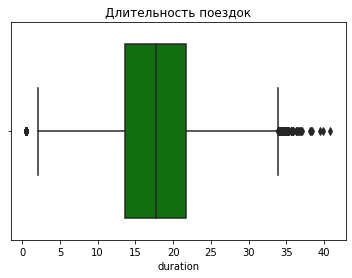

In [26]:
print(rides_df['duration'].describe())
sns.boxplot(x=rides_df['duration'], color='green').set_title('Длительность поездок');

#### Выводы исследовательского анализа:
- ТОП-3 городов, в которых больше всего распространены поездки GoFast: Пятигорск, Екатеринбург и Ростов-на-Дону. В Москве сервис распространен меньше всего, видимо, из-за наличия других крупных компаний и высокой конкуренции;
- Пользователей, оформивших подписку Ultra, почти на треть меньше, чем тех, кто предпочитает использовать сервис без подписки;
- Большинству пользователей 20-25 лет;
- В среднем, пользователи проезжают от 2.5 до 3.5км. Рекордное значение - 7.2км;
- Чаще всего поездки занимают от 15 до 20мин. Рекордное значение - 40мин.

### Объединение данных

#### Объединение данных о пользователях, поездках и подписках в один датафрейм

In [27]:
print(users_df.shape)
df = users_df.merge(rides_df)
df = df.merge(subs_df)
df.shape

(1534, 5)


(18068, 12)

In [28]:
df.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


#### Создание двух датафреймов из основного df:
- С данными о пользователях без подписки;
- С данными о пользователях с подпиской.

In [29]:
df_free = df.query("subscription_type == 'free'")
df_free.reset_index(inplace=True, drop=True)
df_free.head(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
1,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
2,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
3,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
4,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
5,700,Айдар,22,Омск,free,4342.002254,22.368009,2021-02-23,2,8,50,0
6,700,Айдар,22,Омск,free,3798.334905,18.243756,2021-03-03,3,8,50,0
7,700,Айдар,22,Омск,free,2984.551206,15.424899,2021-04-09,4,8,50,0
8,700,Айдар,22,Омск,free,3360.107141,16.765497,2021-06-12,6,8,50,0
9,700,Айдар,22,Омск,free,2567.543847,11.312160,2021-06-23,6,8,50,0


In [30]:
df_ultra = df.query("subscription_type == 'ultra'")
df_ultra.reset_index(inplace=True, drop=True)
df_ultra.head(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


#### Визуализация информации о расстоянии и времени поездок для пользователей обеих категорий

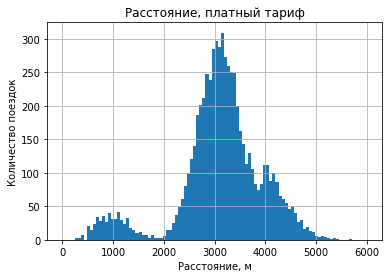

In [31]:
plt.hist(df_ultra['distance'], bins=100, range = (0, 6000))
plt.title('Расстояние, платный тариф')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.grid()
plt.show()

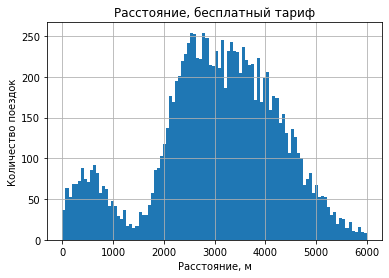

In [32]:
plt.hist(df_free['distance'], bins=100, range = (0, 6000))
plt.title('Расстояние, бесплатный тариф')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.grid()
plt.show()

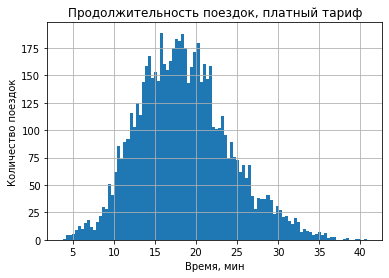

In [33]:
plt.hist(df_ultra['duration'], bins=100)
plt.title('Продолжительность поездок, платный тариф')
plt.xlabel('Время, мин')
plt.ylabel('Количество поездок')
plt.grid()
plt.show()

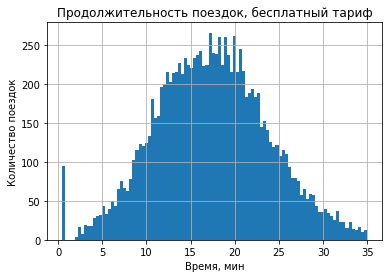

In [34]:
plt.hist(df_free['duration'], bins=100)
plt.title('Продолжительность поездок, бесплатный тариф')
plt.xlabel('Время, мин')
plt.ylabel('Количество поездок')
plt.grid()
plt.show()

#### Выводы объединения данных:
- Три исходных датафрейма были объединены в один df;
- На основе единого датафрейма было создано два новых датасета: пользователи с подпиской (df_ultra), пользователи без неё (df_free);
- Итоги визуализации: 
    - Для бесплатного тарифа: среднее время поездки составляет от 15 до 25 минут, среднее расстояние - от 2 до 4 км; 
    - Для платного тарифа: среднее время поездки составляет от 15 до 20 минут, среднее расстояние - от 2.5 до 3.5 км;
    - Можно заметить, что пользователи с бесплатным тарифом совершают более долгие поездки, а также проезжают бОльшее расстояние, чем пользователи с платным тарифом.

### Подсчёт выручки

#### Создать датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными: найти суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [ ]:
df['duration'] = np.ceil(df['duration'])

In [35]:
df_agg = pd.pivot_table(df, index=['month', 'user_id'],
                            values=['distance', 'duration', 'name', 'subscription_type'],
                            aggfunc={'distance': sum, 'duration': sum, 'name': len, 'subscription_type': min})

In [36]:
df_agg.rename(columns={'name': 'count_trips'}, inplace = True)

In [37]:
df_agg = df_agg.sort_values(by='month')

In [38]:
df_agg.query('user_id == 13')

,,distance,duration,count_trips,subscription_type
month,user_id,,,,
1,13,6687.987446,41.848947,2,ultra
4,13,2809.392221,21.915502,1,ultra
8,13,7450.704663,41.406100,2,ultra
9,13,10170.782925,58.096172,3,ultra
10,13,8950.914857,49.241581,3,ultra
11,13,7274.062022,29.856555,2,ultra
12,13,3504.594002,22.681980,1,ultra


#### В этот же датафрейм добавить столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратимся к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округлить до следующего целого числа.

In [40]:
def revenue(row):
    if row['subscription_type'] == 'ultra':
        return 6 * row['duration'] + 199
    elif row['subscription_type'] == 'free':
        return 8 * row['duration'] + 50 * row['count_trips']
    else:
        return 'Not such sub'

In [ ]:
я

In [41]:
df_agg['revenue_per_month'] = df_agg.apply(revenue, axis=1)

In [42]:
df_agg.query('user_id == 13')

,,distance,duration,count_trips,subscription_type,revenue_per_month
month,user_id,,,,,
1,13,6687.987446,42.0,2,ultra,451.0
4,13,2809.392221,22.0,1,ultra,331.0
8,13,7450.704663,42.0,2,ultra,451.0
9,13,10170.782925,59.0,3,ultra,553.0
10,13,8950.914857,50.0,3,ultra,499.0
11,13,7274.062022,30.0,2,ultra,379.0
12,13,3504.594002,23.0,1,ultra,337.0


#### Выводы подсчёта выручки

- Создан новый датафрейм с агрегированными данными(df_agg) на основе датафрейма с объединенными данными(df);
- Найдено суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц;
- Добавлен столбец с помесячной выручкой, которую принес каждый пользователь.

### Проверка гипотез

#### Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

H_0: Время поездки у пользователей с подпиской = время поездки у пользователей без подписки <br>
H_1: Время поездки у пользователей с подпиской > время поездки у пользователей без подписки

In [56]:
alpha = 0.05
ultra = df_ultra['duration'] 
free = df_free['duration']

results = st.ttest_ind(ultra, free, alternative = 'greater')
print(results.pvalue)

if results.pvalue < alpha:
    print('Пользователи с подпиской тратят больше времени на поездки.')
else:
    print('Время поездки совпадает у пользователей с подпиской и без неё.')

1.2804098316645618e-34
Пользователи с подпиской тратят больше времени на поездки.


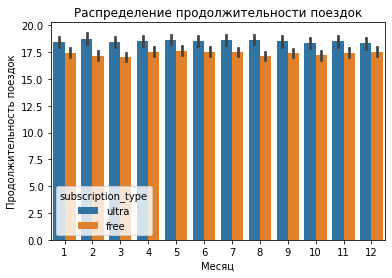

In [55]:
ax = sns.barplot(x='month', y='duration', hue="subscription_type", data=df)
ax.set_title('Распределение продолжительности поездок')
ax.set(xlabel='Месяц', ylabel='Продолжительность поездок');

Вывод: гипотеза о том, что пользователи с подпиской тратят больше времени на поездки, верна.

#### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

H_0: Среднее расстояние поездки у пользователей с подпиской = 3130 <br>
H_1: Среднее расстояние поездки у пользователей с подпиской < 3130

In [57]:
alpha = 0.05
ultra = df_ultra['distance'] 
value = 3130.0

results = st.ttest_1samp(ultra, value, alternative = 'less')
print(results.pvalue)

if results.pvalue < alpha:
    print('Среднее расстояние поездки у пользователей с подпиской не превышает 3130.')
else:
    print('Среднее расстояние поездки у пользователей с подпиской достигает 3130.')

0.08046311521502146
Среднее расстояние поездки у пользователей с подпиской достигает 3130.


Вывод: нельзя утверждать, что среднее расстояние поездки у пользователей с подпиской не превышает 3130.

#### Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

H_0: Помесячная выручка от пользователей с подпиской = выручка от пользователей без подписки. <br>
H_1: Помесячная выручка от пользователей с подпиской > выручка от пользователей без подписки.

In [61]:
alpha = 0.05
ultra = df_agg.loc[df_agg.subscription_type == 'ultra', 'revenue_per_month']
free = df_agg.loc[df_agg.subscription_type == 'free', 'revenue_per_month']

results = st.ttest_ind(ultra, free, alternative = 'greater')
print(results.pvalue)

if results.pvalue < alpha:
    print('Помесячная выручка от пользователей с подпиской превышает выручку от пользователей без подписки.')
else:
    print('Помесячная выручка от пользователей с подпиской и без совпадает.')

2.8130926188487286e-35
Помесячная выручка от пользователей с подпиской превышает выручку от пользователей без подписки.


Вывод: гипотеза о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки, верна.

#### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Необходимо использовать метод st.ttest_rel(), так как мы сравниваем средние значения двух зависимыми выборок.<br>
<br>
H_0: Среднее количество обращений в техподдержку до изменений = среднее количество обращений в техподдержку после изменений. <br>
H_1: Среднее количество обращений в техподдержку после изменений уменьшилось.

### Распределения

#### Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. <br> Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

Данная акция может быть описана биномиальным распределением. Пусть n - количество клиентов, продливших подписку из N клиентов, которые воспользовались промокодом. Вероятность продления подписки для каждого клиента, равна p=0.1, так как 10% пользователей продлевают подписку.

Тогда вероятность того, что не менее 100 клиентов продлят подписку при использовании промокодов, составляет: 
P(n ≥ 100) = 1 - P(n < 100)

Вероятность не выполнить план составляла примерно 5%. То есть, мы хотим найти такое минимальное N, при котором P(n ≥ 100) ~ 0.05.

In [79]:
p = 0.1
target_prob = 0.05
min_promo = 1

while True:
    distr = st.binom(min_promo, p)
    prob = 1 - distr.cdf(99)

    if prob >= target_prob:
        break
    min_promo += 1

print(f'Минимальное количество промокодов: {min_promo}')

Минимальное количество промокодов: 850


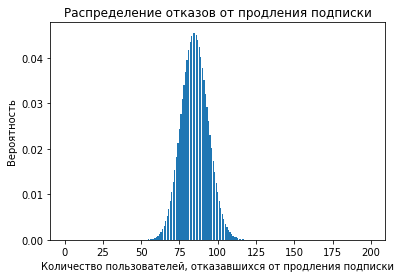

In [80]:
x = range(1, 200)
y = st.binom.pmf(range(1, 200), min_promo, p)

plt.bar(x, y)
plt.xlabel('Количество пользователей, отказавшихся от продления подписки')
plt.ylabel('Вероятность')
plt.title('Распределение отказов от продления подписки')
plt.show()

#### Вывод: 
- Заданная ситуация описывается биномиальным распределением с параметрами n = 850 и p = 0.1;
- Минимальное количество промокодов, которое надо разослать, - 850 штук.

#### Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Для оценки вероятности того, что уведомление откроют не более 399,5 тыс. пользователей, мы можем использовать нормальное распределение как аппроксимацию биномиального распределения при большом количестве наблюдений.

Для данной задачи мы знаем, что вероятность открытия уведомления составляет 40%, то есть p = 0.4. Количество уведомлений, которые планируется разослать, равно 1 млн, то есть n = 1,000,000.

Для аппроксимации используем среднее значение µ = n * p и стандартное отклонение σ = sqrt(n * p * (1 - p)). Затем можем использовать функцию нормального распределения для оценки вероятности.

In [90]:
p = 0.4
n = 1000000
target = 399500

mu = n * p
std = np.sqrt(n * p * (1-p))

distr = st.norm(mu, std)
prob = distr.cdf(target)

print(f"Вероятность открытия не более 399,5 тыс. пользователей: {round(prob, 2)}")

Вероятность открытия не более 399,5 тыс. пользователей: 0.15


#### Вывод: 
- Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей, - 0.15

### Общий вывод:
- Работа производилась с 3 датасетами: информация о пользователях, о поездках, о подписках;
- Проведена предобработка данных:
    - Столбец date переведен к типу datetime64;
    - В датафрейме rides_df создан новый столбец (Месяц совершения поездки);
    - Пропущенные значения ни в одном датасете найдены не были;
    - Выявлены и удалены 31 дубликат в users_df;
    - В rides_df subs_df дубликаты отсутствуют.
- Проведен исследовательский анализ:
    - ТОП-3 городов, в которых больше всего распространены поездки GoFast: Пятигорск, Екатеринбург и Ростов-на-Дону. В Москве сервис распространен меньше всего, видимо, из-за наличия других крупных компаний и высокой конкуренции;
    - Пользователей, оформивших подписку Ultra, почти на треть меньше, чем тех, кто предпочитает использовать сервис без подписки;
    - Большинству пользователей 20-25 лет;
    - В среднем, пользователи проезжают от 2.5 до 3.5км. Рекордное значение - 7.2км;
    - Чаще всего поездки занимают от 15 до 20мин. Рекордное значение - 40мин.
- Три исходных датафрейма были объединены в один df;
- На основе единого датафрейма было создано два новых датасета: пользователи с подпиской (df_ultra), пользователи без неё (df_free);
- Замечанно на графиках:
    - Для бесплатного тарифа: среднее время поездки составляет от 15 до 25 минут, среднее расстояние - от 2 до 4 км;
    - Для платного тарифа: среднее время поездки составляет от 15 до 20 минут, среднее расстояние - от 2.5 до 3.5 км;
    - Можно заметить, что пользователи с бесплатным тарифом совершают более долгие поездки, а также проезжают бОльшее расстояние, чем пользователи с платным тарифом.
- Создан новый датафрейм с агрегированными данными(df_agg) на основе датафрейма с объединенными данными(df);
- Найдено суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц;
- Добавлен столбец с помесячной выручкой, которую принес каждый пользователь.
- Проверены 3 гипотезы. Итоги:
    - Гипотеза о том, что пользователи с подпиской тратят больше времени на поездки, верна;
    - Нельзя утверждать, что среднее расстояние поездки у пользователей с подпиской не превышает 3130;
    - Гипотеза о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки, верна.
- Минимальное количество промокодов, которое надо разослать, - 850 штук;
- Вероятность того, что push-уведомление откроют не более 399,5 тыс. пользователей, - 0.15